## Test zonal mean files to compute lat-lon av plot

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import num2date
import func as f
import pandas as pd

In [2]:
era5 = xr.open_dataset('FULL-ERA5.tp.monzonmean.2000-2018.nc4')
obs = xr.open_dataset('GPS-RO__CP_LR_5x5_2007-2018.nc')

In [3]:
test_wa = xr.open_dataset('test_wa.nc')
obs_wa = xr.open_dataset('obs_wa.nc')
cdo_aw = xr.open_dataset('cdo_aw_era5.nc')
cdo_aw2 = xr.open_dataset('cdo_mermean2.nc')
obs_cdo_wa = xr.open_dataset('obs_fldmean.nc')

In [4]:
era5.time

<xarray.DataArray 'time' (time: 228)>
array(['2000-01-01T00:00:00.000000000', '2000-02-01T00:00:00.000000000',
       '2000-03-01T00:00:00.000000000', ..., '2018-10-01T00:00:00.000000000',
       '2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2018-12-01
Attributes:
    long_name:  time

In [5]:
obs_wa = obs_wa.resample(time='M').mean()

In [6]:
wa_nco = np.asarray(test_wa.ctpt.sel(time= slice('2007-01-01', '2018-12-01')))

In [7]:
ds_era5 = era5.sel(lat=slice(-20,20) , time = slice('2007-01-01', '2018-12-01'))

In [8]:
obs_res = obs.resample(time='M').mean()
obs_mon = obs_res.sel(lat=slice(-20,20))

In [9]:
wa_cdo = np.asarray(cdo_aw.ctpt[:,0,0].sel(time=slice('2007-01-01', '2018-12-01')))
wa_cdo2 = np.asarray(cdo_aw2.ctpt[:,0,0].sel(time=slice('2007-01-01', '2018-12-01')))
cdo_obs = obs_cdo_wa.resample(time='M').mean()

In [10]:
def get_wghts(lat):
    """
    get latitude weights for gaussian grid.
    :param lat: latitudes
    :return: weights
    """
    latr = np.deg2rad(lat) # convert to radians
    weights = np.cos(latr) # calc weights
    return weights


def w_average(ds, var):
    mean = np.zeros([len(var),ds.time.shape[0]])
    w = get_wghts(ds.lat)

    _, weights_all_dims = xr.broadcast(ds, w)
    for i in range(len(var)):
        for t in range(ds.time.shape[0]):
            mean[i,t] = (ds[var[i]][t,:].mean()*weights_all_dims).sum(skipna=True)/weights_all_dims.sum(skipna=True)

    return mean


In [11]:
ds = ds_era5
var = ['ctpt', 'ctpz']
t1 = w_average(ds,var)

In [12]:
obs_cpt = np.asarray(obs_wa.CP_T)
obs_cdo_aw = np.asarray(cdo_obs.CP_T[:,0,0])

In [13]:
wa_cdo - obs_cdo_aw

array([-0.14746094, -0.03277588,  0.07463074, -0.01228333, -0.10186768,
       -0.03335571, -0.02687073,  0.01049805, -0.06542969, -0.07124329,
       -0.21469116, -0.19316101, -0.28901672, -0.16908264, -0.16029358,
       -0.20671082, -0.25257874, -0.13218689,  0.02102661,  0.08468628,
        0.05130005,  0.07733154, -0.0684967 , -0.12077332, -0.06846619,
        0.04949951, -0.05220032, -0.10365295, -0.13119507, -0.05239868,
        0.06416321,  0.05587769, -0.04029846, -0.03996277, -0.1111908 ,
       -0.11729431, -0.09638977, -0.10423279,  0.04550171, -0.11695862,
       -0.2517395 , -0.09988403, -0.12506104, -0.17480469, -0.11834717,
       -0.280365  , -0.20611572, -0.11656189, -0.10317993, -0.03269958,
        0.05439758, -0.05947876, -0.16253662, -0.063797  ,  0.05212402,
        0.03184509,  0.09005737, -0.0422821 , -0.08218384, -0.1325531 ,
       -0.15008545, -0.00520325, -0.01123047, -0.11256409, -0.11018372,
       -0.00979614, -0.09498596, -0.06759644, -0.06872559, -0.07

In [14]:
ds2 = obs_mon
var2 = ['CP_T', 'CP_z']
t2 = f.w_average(ds2,var2)

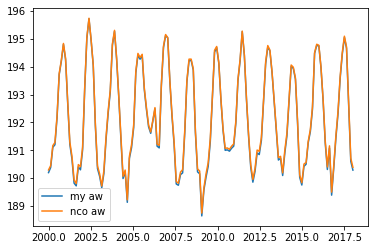

In [15]:
yr = np.asarray(np.linspace(2000,2018,len(t1[0])))
plt.plot(yr, t1[0], label = 'my aw')
plt.plot(yr, wa_nco, label = 'nco aw')

plt.legend()

Text(0, 0.5, 'Temperature difference [K]')

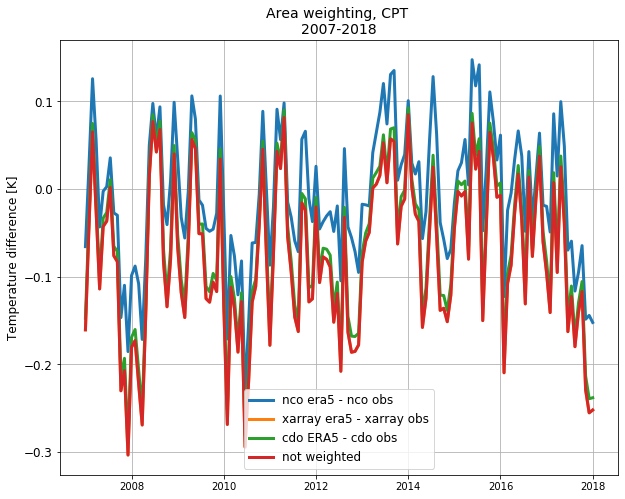

In [18]:
y2  = np.linspace(2007, 2018, 144)
obs_cpt = np.asarray(obs_wa.CP_T)

plt.figure(figsize=(10,8))
plt.plot(y2, wa_nco - obs_cpt, lw=3, label = 'nco era5 - nco obs')
plt.plot(y2,t1[0] - t2[0], lw=3, label = 'xarray era5 - xarray obs')
plt.plot(y2, wa_cdo - obs_cdo_aw, lw=3, label='cdo ERA5 - cdo obs')
plt.plot(y2, ctpt_mean - obs_mean, lw = 3,label = 'not weighted')


#plt.xlim(2007.6, 2008.4)
plt.legend(fontsize=12)
plt.title('Area weighting, CPT \n2007-2018', fontsize=14)
plt.grid()
plt.yticks(fontsize=12)
plt.ylabel('Temperature difference [K]', fontsize = 12)

#plt.xticks([2007.6, 2007.7,2007.8, 2007.9, 2008.0, 2008.1, 2008.2, 2008.3, 2008.4],
#           ['sep 07','oct 07','nov 07', 'dec 07', 'jan 08', 'feb 08', 'mar 08', 'apr 08', 'may 08'], fontsize=12)
#plt.savefig('aw_diff_2007-2008.pdf')

NameError: name 't2' is not defined

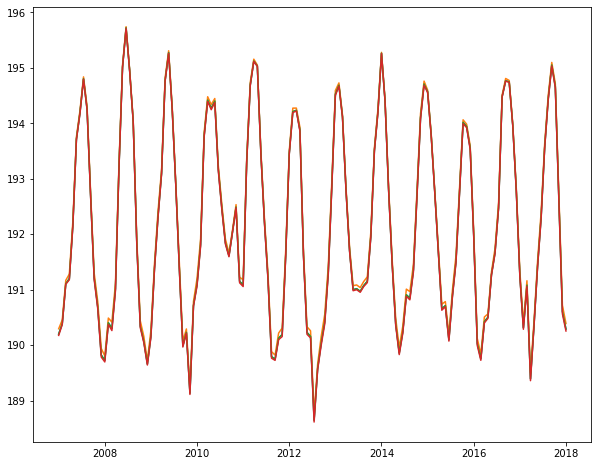

In [28]:
plt.figure(figsize=(10,8))
plt.plot(y2, t1[0], label = 'xarray aw')
plt.plot(y2, wa_nco, label = 'nco aw')
plt.plot(y2, ctpt_mean, label = 'not aw')
plt.plot(y2, wa_cdo, label = 'cdo aw')
plt.plot(y2, t2[0], lw = 2, label = 'xarray obs aw')
plt.plot(y2, obs_cpt, lw = 2, label = 'nco obs aw')
plt.xlim(2007.8,2008.2)
plt.ylim(189.6,191.5)
plt.legend()

In [17]:
obs_mean = np.zeros(obs_mon.time.shape[0])
ctpt_mean = np.zeros(ds_era5.time.shape[0])

for i in range(len(obs_mean)):
    obs_mean[i] = obs_mon.CP_T[i,:,:].mean()
    ctpt_mean[i] = ds_era5.ctpt[i,:].mean()

In [25]:
## Look at what happened in end 2007- beginning of 2008

era5_cold = wa_nco[10:16]
obs_cold = obs_cpt[10:16]

In [26]:
df = pd.DataFrame({'ERA5': wa_nco[10:20], 'OBS' : obs_cpt[10:20]  , 'ERA5-OBS' : wa_nco[10:20] - obs_cpt[10:20]})


In [27]:
ds_era5.time[10:14]

<xarray.DataArray 'time' (time: 4)>
array(['2007-11-01T00:00:00.000000000', '2007-12-01T00:00:00.000000000',
       '2008-01-01T00:00:00.000000000', '2008-02-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2007-11-01 2007-12-01 2008-01-01 2008-02-01
Attributes:
    long_name:  time

In [131]:
df

,ERA5,OBS,ERA5-OBS
0,191.301285,191.447998,-0.146713
1,190.790375,190.900269,-0.109894
2,189.940018,190.125504,-0.185486
3,189.806702,189.905411,-0.098709
4,190.488327,190.576309,-0.087982
5,190.415161,190.523392,-0.108231
6,191.113419,191.285019,-0.171600
7,193.280197,193.359970,-0.079773
8,195.051117,195.001343,0.049774
9,195.740921,195.643433,0.097488
